Este notebook tem como motivação, ensinar de forma simples, prática e direta o básico de PyTorch. Alguns assuntos serão abordados em um notebook futuro com outro exemplo.

Neste notebook temos o objetivo de com uma rede neural, conseguirmos classificar imagens de cartas de baralho. Este é um projeto que utiliza os dados do kaggle deste link:

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

A ideia é ser algo simples, com comentários de por que cada coisa no código está ali. Então vamos começar:

O processo de treinamento de uma rede neural possa ser dividido em 4 partes:
- Organizar os dados de uma forma que o modelo entenda
- Definir o modelo
- Treinar o modelo
- Avaliar os resultados

In [ ]:
# Essa célula é para baixar os dados do kaggle.
# Aqui talvez precise das suas credenciais do kaggle. Vá em settings, API, create new token, abrir arquivo no txt e pegar infos lá.
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: brayanrafael97
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification


100%|██████████| 385M/385M [00:03<00:00, 126MB/s] 


Organizando o Modelo:

Primeiramente vamos importar os pacotes e funções que vamos utilziar no nosso projeto:

Notar que já existem comentários sobre os pacotes em frente deles, porém ao utilizarmos as funções terão explicações do que cada um faz.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision #pacote com funções uteis para imegens
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder #Função útil para lidar com imagens em pastas.
import timm #está aqui para importar arquiteturas que já foram treinadas com imagens para não fazermos do zero

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2



PASSO 1 - Organizar e transformar os dados

Podemos dividir esse processo em dois passos:
  - Criar a nossa função que vai transformar os dados para um formato que o modelo entenda
  - Criar nosso Dataloader, que é basicamente uma função que nos permite treinar nosso modelo em batches (grupos) de forma paralelizada, diminuindo em muito nosso tempo de treinamento.

Neste ponto vamos criar uma classe em Python para que possamos utilizar as funções necessárias.

Basicamente precisamos de uma função que nos retorna 3 itens essenciais e um útil.

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None): #informa oque a função deve fazer ao ser criada
        self.data = ImageFolder(data_dir, transform=transform)
        #a função ImgeFolder do pacote "transform" assume que o o nome das subpastas em um diretório possuem o nome da classe e já cria autoaticamente o nome das classes (exemplo: cada pasta dentro de "test" tem o nome da carta)

    def __len__(self): #informa para o dataloader quantos exemplos tem no banco de dados ao ser criado
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] #retorna o item do dataset, no caso retornará a imagem e a classe que o index for chamado na função

    @property
    def classes(self):
        return self.data.classes #retorna a classe da imagem

O que nossa classe retorna para nós:

Ao ser iniciada, ela cria as classes pelo nome das pastas e aplica uma transformação nos dados, caso tenha uma [__init__]

Transformação:

Aplicamos alguma função que modifica nossas imagens para que elas se tornem consistentes. No nosso modelo, vamos aplicar uma transformação de alterar o tamanho, todas as imagens terão o mesmo tamanho e serão transformados em tensores.

Tensores são como um array do pandas, porém em um formato que a rede neural consegue entender, ou seja, valores numéricos.

Retorna o tamanho dos nossos dados, ou seja, quantos exemplos totais existem [__len__]

Retorna o item do dataset em si, por um index [__getitem__]

Por fim, podemos retornar apenas a classe da imagem [classes]. O @property é utilizado apenas para esconder os parenteses e poder ser chamado nome_classe.classes ao invés de nome_classe.classes(). Este passo não é obrigatório, o modelo roda normalmente sem essa parte, porém ela serve para entendermos qual classe representa qual número. Dado que o modelo cria números de classes e trabalha com ele desta forma, este passo nos permite criar um dicionário para entendermos qual número está associado a qual classe, no nosso caso, a qual carta de baralho.

Uma vez definido nossa classe, vamos testar para ver se ela funciona. Vamos "jogar" nossas imagens de treino no nosso modelo de classe para testar.

In [ ]:
dataset = PlayingCardDataset(
    data_dir='//content/cards-image-datasetclassification/train'
)

In [ ]:
len(dataset)

7624

41


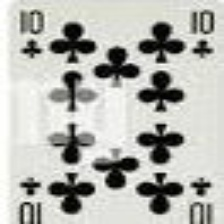

In [ ]:
image, label = dataset[6000]
print(label)
image

Neste passo abaixo criaremos nosso dicionário com qual número de classe representa qual carta. Lembrando, não é um passo obrigatório, apenas para facilitar entendimento

In [ ]:
data_dir = '//content/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

Após definir nossa classe para deixar nossos dados em um formato que o modelo entenda, vamos efetivamente alterar nossos dados para o futuro treinamento.

Vamos definir nossa transformação que ocorrerão nos dados. Ela ocorre na função Compose do pacote transforms. Basicamente ela permite que realizemos diversas transformações na imagem numa mesma função.

Resize() permite alterar o tamanho da imagem em pixels horizontal e vertical

ToTensor() converte a imagem para um numpy arrey de valores normalizados entre 1 e 0.

Existem diversas outras funções dentro do pacote para realizaras transformações. Em outros projetos veremos mais algumas mas é bom pesquisar.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '//content/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

Notar que desta vez, atribuimos nossa transformação (transform) a nossa classe criada inicialmente.

Vamos verificar as alterações.

In [ ]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [ ]:
image

tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0078, 0.0431,  ..., 0.0196, 0.0039, 0.0078],
         [0.0235, 0.0392, 0.3490,  ..., 0.2392, 0.0314, 0.0118],
         ...,
         [0.0039, 0.0235, 0.2392,  ..., 0.2196, 0.0314, 0.0118],
         [0.0039, 0.0039, 0.0235,  ..., 0.0118, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0392,  ..., 0.0196, 0.0039, 0.0078],
         [0.0078, 0.0275, 0.3373,  ..., 0.2392, 0.0275, 0.0078],
         ...,
         [0.0039, 0.0235, 0.2431,  ..., 0.2196, 0.0314, 0.0078],
         [0.0039, 0.0039, 0.0235,  ..., 0.0157, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0039]],

        [[0.0196, 0.0196, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0078, 0.0353,  ..., 0.0157, 0.0039, 0.0078],
         [0.0118, 0.0196, 0.3137,  ..., 0.2196, 0.0235, 0.

Vimos que nossa imagem passou a ter um shape com 3 valores, um para o eixo x e outro para o eixo y com tamanhos 128 pixels e 3 valores representando os canais RGB dos pixels.

Ver que nossa imagem passou a ser um grande array com 3 valores para cada pixel.

Uma vez que nossas alterações estão concluídas, vamos criar nosso DataLoader. Como dito acima, ele basicamente divide nosso banco de dados inicial em grupos de tamanho N (batch_size) e com eles conseguimos paralelizar nosso treinamento. Vale notar que podemos pedir para o batch randomizar a escolha dos elementos para o grupo ou não. Normalmente randomizamos para treinamento, porém para o teste, não fazemos isso para um controle maior.

Outro ponto importante a ser dito sobre o DataLoader é que ele nos retorna objetos iteraveis, oque é útil e será utilizado em vários momentos do código, através de códigos for.

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    break

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([18, 50, 11,  4,  2, 38,  0,  1,  7, 33, 11, 43,  5,  5, 39, 37, 38, 50,
        13,  7, 25, 14,  5, 24, 30,  2, 14, 35, 26, 29, 26, 52])

Vemos que nosso dataloader funciona, ele retornou 32 elementos, e iterou através de todo o dado.

Vale notar que o valor 32 para o tamanho do batch foi escolhido de forma arbitrária, porém é normalmente usado como um bom valor padrão para treinamento.

Outro ponto a se perceber é que nosso dataloader altera nosso shape dos dados, agora ele mostra que temos 32 observações e eles estão aleatorizados.

Parabéns, com isso terminamos nosso primeiro passo e organizamos nossas imagens de uma forma que o modelo consiga entender.

PASSO 2 - Definir o modelo.

Nesta parte teremos que explicar algumas coisas para que faça sentido.

A primeira coisa a se notar, é que neste projeto, não efetivamente criaremos um modelo, mas utilizaremos um já pronto e conhecido, que costuma ter bons resultados para classificação de imagens quando não se tem tantos dados quanto neste projeto. Quando falamos de muitos dados para projetos de redes neurais, isso inclui milhões e milhões de features. O modelo utilizado é o "effcientnet_b0".

Usaremos este modelo pronto, isso inclui utilizar todas as camadas e transformações já incluídas nele, além de utilizar os pesos que o treino dele resultou. Com isso, podemos utilizar todo o aprendizado que o modelo teve anteriormente e aplicarmos em nosso projeto, sem precisarmos criar e otimizar, e realizar todo o processo de aprendizado e testes.

Com isso definido, precisamos definir diversos termos para que o processo fique claro, mas antes disso, acho importante notar qual a ordem das ações para um modelo ser treinado.

1- Definimos o modelo ou as layers do modelo. Será melhor explicado a frente.

2- Fazemos nossa primeira predição. (forward)

3- Calculamos a nossa função de perca (loss function)

4- O erro é calculado através das camadas para entender o peso de cada camada
para tal. São calculados os gradientes através de derivadas. (backpropagation)

5- O otimizador recalcula os pesos utilizados no aprendizado utilizando o gradiente calculado anteriormete. (update)

6- O processo é repetido até os batches acabar. Isso é chamado de uma época(epoch). Uma vez que uma epoch terminou, esse processo se repete por várias epochs e o modelo vai melhorando seus pesos.

Observação:

O chat gpt realizou uma ótima explicação com uma analogia do assunto, estarei colocando no final do código como um anexo para quem quiser entender melhor.

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # definimos todas as partes do modelo
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # Esta linha aqui está para retirar a última linha do modelo pra que possamos criar uma previsão para o nosso tamanho de classes (abaixo)

        enet_out_size = 1280
        # Fazemos o classificador, ultima camada do modelo
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # conecta as partes acima. É onde realmente ocorre a mudança e vemos a saída dos pesos
        x = self.features(x)
        output = self.classifier(x)
        return output

Vamos entender um pouco melhor nosso código de definição do modelo:

Criamos uma classe que será nosso modelo utilizado no treinamento e herdamos o (nn.Module). Basicamente com ele, herdamos todas as funções básicas para podermos utilizar o PyTorch em redes neurais. Sempre será utilizado.

o super() utilizado no código também sempre será chamado, por que ele serve para deixar o código intuitivo, ele exclui nosso código de sempre termos de usar nn.module
antes dos comandos na nossa classe. Senão ficaria assim: nn.Module.__init__(self)

Nas duas linhas abaixo, é onde importamos o modelo e seus pesos de treinamento e retiramos sua última camada, ou seja, excluímos a camada que ele preve para as N classes que ele foi treinado. No caso deste modelo, ele retorna um valor de 1280 neurônios(classes) e nosso modelo tem 53, por isso excluímos essa camada e criamos a nossa, no nn.Sequential.

Em um outro projeto que criaremos nosso próprio modelo, isso será visto com mais detalhes, porém na nossa primeira camada são incluídos o número de imagens que temos para treinar, e na última, é incluída um total de classes que temos como saída. Assim nosso modelo retorna uma probabilidade para cada classe.

Já no nosso classificador (notar que aqui já pegamos o modelo anterior e ele é carregado para essa etapa), usamos o nn.Flatten() que basicamente transforma nosso tensor de 3 dimensões para uma só. Isso por que nossa camada nn.Linear que é nossa saída final para as 53 classes só aceita vetores assim. Essa transformação acontece com ele mantendo o tamanho do batch e multiplicando as outras dimensões

No forward, temos que x recebe os dados que o dataloader nos traz e ele aplica com eles o "modelo" acima, no caso as nossas camadas de mudanças. Com isso temos a primeira saída desse modelo.


In [ ]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

Aqui vamos testamos para ver se nosso modelo está funcionando com nossos datos que criamos no passo 1. Vemos que ele entendeu, e que gerou valores para nosso exemplo, e que mais que isso, tem um shape final de 53 valores, oque são nossas classes no final. Portanto ele está funcionando corretamente.

Parabéns, chegamos ao final do nosso segundo passo. Com oque temos até agora, podemos começar o treinamento da nossa rede neural.

PASSO 3 - Treinamento da rede neural

Aqui é onde realmente vamos treinar nossa rede neural, até este momento estavamos apenas organizando as coisas. Para treinar, primeiramente precisamos definir nossa função de perca (loss function) e otmizador (optimizer).

A função de loss calcula quanto as previsões estão próximas dos valores reais.

Já o adaptador é o responsável por calcular os novos pesos, depois do cálculo do gradiente. Para o projeto usamos os dois mais comuns para essa situação de classificação múltipla. lr no código representa a learning rate, ou seja, a taxa de aprendizado do adaptador. É um valor que determina os "passos" que o adaptador usa para os cálculos dos próximos passos. Se for grande demais, ele avança muito rápido nos pesos e ultrapassa o ponto ótimo, enquanto se for pequena demais, ele levará um número muito grande de repetições para chegar no ponto ideal oque gera um gasto computacional

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss() #Função comum para casos de classificação multipla
# Optimizer
#optimizer mais comum. Seria o "padrão" utilizado para a maioria dos casos. lr é a learning rate.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# caso de teste para testar se a função de perca está funcionando. Aqui estamos utilizando no output de exemplo que criamos acima
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


Uma vez que definimos isso, vamos realizar o treinamento dos dados.

Inicialmente vamos realizar nossa transformação em todos os dados que temos. Como este é um exemplo do kaggle, já nos vieram dados separados em treino, validação e os dados finais para teste. Caso não tenham essa separação, será necessário realiza-la manualmente antes de executar esse processo.

Nesta próxima célula, aplicaremos nossa classe nos dados que temos, e já aplicaremos o DataLoarder também. Vale ressaltar, como dito anteriormente que nos dados de validação e teste, setamos os shuffle=False.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/cards-image-datasetclassification/train'
valid_folder = '/content/cards-image-datasetclassification/valid'
test_folder = '/content/cards-image-datasetclassification/test' #Este aqui seria os dados para teste final. Não é utilizado para o treino, mas foi realizado aqui mesmo.

# Aqui criamos os datasets no formato para o modelo e já criamos os dataloaders de cada um.
train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Loop de treinamento
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #estamos utilizando o gpu caso tenha

model = SimpleCardClassifer(num_classes=53)
model.to(device) #estamos setando para o modelo rodar no gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Fase treinamento
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5913059404989605, Validation loss: 0.3610350082505424


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5485112827822394, Validation loss: 0.28756925261245586


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3406445585261612, Validation loss: 0.14912644523494648


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2193485043028219, Validation loss: 0.10635423795232234


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1906680072592288, Validation loss: 0.18428816570425932


Vamos analisar essa parte do código e oque cada parte está especificamente fazendo.

Vamos começar sobre as partes do código que referenciam-se a device. Essa é a parte do código que nos permite alterar o nosso loop de treinamento para VGU para podermos paralelizar e rodar mais rápido o processo.

Nas partes que temos o tqdm, eles aparecem basicamente nos loops de for. Essa adição é responsável para vermos uma barra de progresso do nosso processo. É apenas uma adição estética, não influencia em nada no treinamento da rede neural.

Uma vez que temos isso definidos, vou passar por cada linha do loop sobre oque está acontecendo, acredito ser mais fácil de entender o processo dessa forma.

model.train()

Seta o modelo para o modo de treinamento, ou seja, neste momento o modelo ao rodar tem seus pesos ajustados. Caso queiramos manter o peso do treinamento e só utilizarmos para avaliar resultados usamos model.eval()

running_loss = 0.0

a variável running_loss soma as percas que houveram em cada batch do nosso dataloader. Quando 1 epoch termina, é necessário zerar para vermos os valores novamente, no novo ciclo. O esperado é que este valor vá diminuindo, dado que o modelo está aprendendo e reduzindo os erros.

optimizer.zero_grad()

É zerado os gradientes para os cálculos dos pesos. Isso é necessário para que não haja soma dos gradientes entre batches diferentes. Por isso é ideal zerar. Não ter esse passo resulta em modelos instáveis com erros na atribuição de pesos do modelo.


outputs = model(images)

Aqui é onde ocorre o forward, basicamente retorna nossos valores pós passar pelo modelo que definimos acima.

loss = criterion(outputs, labels)

É calculado a perca. Assim como anteriormente, comparamos os outputs do modelo com os reais labels deles e resulta no valor.

loss.backward()

Neste passo, são calculados via backpropagation os erros para cada passo. Esses novos gradientes calculados serão utilizados para atualizar os pesos da rede neural.

optimizer.step()

Neste passo que o modelo realmente "aprende", pois é só agora que o modelo tem seus pesos atualizados. Isso acontece de forma que ele utiliza os gradientes calculados no passo anterior e utiliza de sua fórmula específica e de sua lr para atualizar estes pesos. Cada optimizer tem sua própria fórmula de fazer isso.

running_loss += loss.item() * labels.size(0)

Calculamos a soma total de perca do batch. Loss.item() retorna a média da perca do grupo e labels.size() retorna o número de elementos no batch. Com isso ao passarmos por todos os batches teremos a soma total das percas daquele epoch.

train_loss = running_loss / len(train_loader.dataset)

Nesta parte calculámos a média do erro de todo epoch. Ao pegarmos a soma total dos erros e dividirmos pelo número de batcehs total usados, nos resultando na média de erros da epoca.


train_losses.append(train_loss)

Nesta parte apenas salvamos esse valor para que possamos acompanhar no futuro o desenvolvimento do valor das percas no treinamento. O esperado é que com o número maior de ciclos, a perca vai diminuindo

Loop de validação:

É praticamente igual ao de treinamento, porém com duas diferenças. Utilizamos o dataloader de validação no nosso for e usamos o model.eval() inicialmente. Com isso, os pesos do modelo não são atualizados e utilizamos oque adquirimos do treinamento.

Vamos observar como foi essa perca ao longo dos ciclos de treinamento

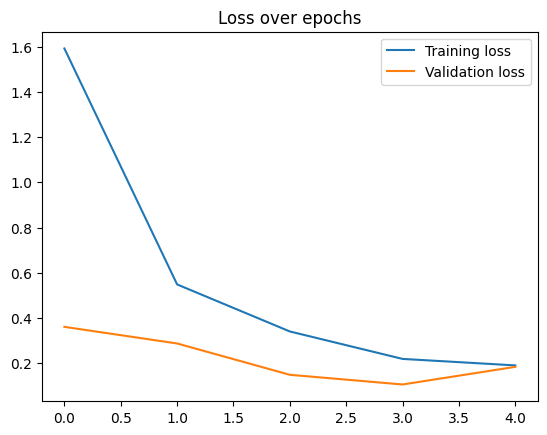

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

PASSO 4 - Avaliação de resultados

A partir deste momento, vamos ver os resultados do nosso treinamento. Para isso, calcularemos a precisão e o recall. Faremos isso para a rede como um todo, ou seja, agregando todas as classes, mas também veremos individualmente as categorias, para entendermos onde que o modelo errou.

Novamente teremos um loop de avaliação do modelo. Com ele, passaremos pelo loader de teste, e predizer os resultados com a função torch.max(). Ela retorna apenas a classe com maior probabilidade segundo o modelo.

Vale notar que salvaremos esses resultados num vetor, isso é útil por que temos poucas imagens no conjunto de teste, então em muita situações, não teremos todas as classes quando selecionarmos um batch e isso pode acabar fazendo a conta errar. Com essa alteração, conseguimos calcular estas medidas no vetor e assim termos certeza dos valores resultantes.


In [ ]:
from torchmetrics.functional import precision, recall

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatena todas as predições e rótulos
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calcula métricas por classe de forma precisa
precision_per_class = precision(all_preds, all_labels, task="multiclass", num_classes=53, average='none')
recall_per_class = recall(all_preds, all_labels, task="multiclass", num_classes=53, average='none')

# calcula métricas gerais
precision_all = precision(all_pred, all_labels, task="multiclass", num_classes=53, avarege="macro")
recall_all = recall(all_pred, all_labels, task="multiclass", num_classes=53, avarege="macro")

print(f"precision: {precision_all}")
print(f"recall: {recall_all}")

# Exibe as métricas
for i, class_name in enumerate(test_dataset.classes):
    print(f"{class_name:<25} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f}")


ace of clubs              | Precision: 1.0000 | Recall: 1.0000
ace of diamonds           | Precision: 1.0000 | Recall: 1.0000
ace of hearts             | Precision: 1.0000 | Recall: 1.0000
ace of spades             | Precision: 1.0000 | Recall: 1.0000
eight of clubs            | Precision: 0.8333 | Recall: 1.0000
eight of diamonds         | Precision: 1.0000 | Recall: 1.0000
eight of hearts           | Precision: 1.0000 | Recall: 1.0000
eight of spades           | Precision: 0.8333 | Recall: 1.0000
five of clubs             | Precision: 1.0000 | Recall: 0.6000
five of diamonds          | Precision: 1.0000 | Recall: 0.8000
five of hearts            | Precision: 0.8333 | Recall: 1.0000
five of spades            | Precision: 1.0000 | Recall: 1.0000
four of clubs             | Precision: 1.0000 | Recall: 0.8000
four of diamonds          | Precision: 1.0000 | Recall: 1.0000
four of hearts            | Precision: 1.0000 | Recall: 1.0000
four of spades            | Precision: 1.0000 | Recall:

Podemos ver que nossa rede neural possui um ótimo resultado para prever as cartas de baralho, com resultados de precisão e recall próximos de 95%. Podemos ver que algumas classes possuem resultados um pouco abaixo, ma com exeção da classe joker que possui um recall bem baixo (0.2) vemos que o resultado geral é satisfatório para todas as classes.

Para melhorar o processo poderíamos deixar a rede neural treinar por mais épocas, só tomando cuidado com overfitting (quando no gráfico, nosso erro de treino diminuiria, porém para a validação começaria a aumentar muito).

Poderíamos aplicar algumas outras transformações nas imagens de treino para ver se o resultado melhoraria, como retirar a cor das imagens para teste, ou mesmo "adicionar" novas imagens com rotações randômicas, assim a rede neural poderia aprender essas pequenas variações na direção. Mas no geral, o resultado ficou positivo.

Importante:

Nenhum desses próximos passos são usados para treinar ou avaliar o modelo, porém eles podem ser usados para entender o resultado retornado nas nossas métricas.

As próximas duas células são células relevantes no contexto de tentar entender a previsão da rede neural a nível individual, ou seja, podemos olhar a imagem e entender exatamente oque o modelo previu para aquela carta.

Na primeira célula, podemos olhar as previsões para a classe escolhida. Para o exemplo, escolhi a classe "joker" que possui resultados baixissimos para o recall. Podemos ver que o modelo previu diversas classes diferentes para o joker.

Na segunda célula temos uma visão das previsões e probabilidades de cada classe para uma carta específica que escolher, através do link da carta.

In [ ]:
# Parâmetros
classe_alvo = "joker"
indice_alvo = class_names.index(classe_alvo)

# Lista para salvar os erros
falsos_positivos = []
falsos_negativos = []


# Dataset com caminhos completos
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Recria o dataset com caminhos (caso não tenha acesso)
test_dataset = ImageFolder(root="/content/cards-image-datasetclassification/test", transform=transform)  # ajuste esse caminho
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(tqdm(test_loader)):
        image = image.to(device)
        label = label.item()
        output = model(image)
        pred = torch.argmax(output, dim=1).item()

        img_path, _ = test_dataset.samples[i]  # caminho do arquivo de imagem

        # Falso positivo: previu como jack of diamonds, mas não era
        if pred == indice_alvo and label != indice_alvo:
            falsos_positivos.append((img_path, class_names[label]))

        # Falso negativo: era jack of diamonds, mas previu errado
        if label == indice_alvo and pred != indice_alvo:
            falsos_negativos.append((img_path, class_names[pred]))

# Exibindo os falsos positivos
print(f"\n=== FALSOS POSITIVOS para '{classe_alvo}' ===")
for path, real_class in falsos_positivos:
    print(f"Predito como '{classe_alvo}', mas era '{real_class}': {path}")

# Exibindo os falsos negativos
print(f"\n=== FALSOS NEGATIVOS de '{classe_alvo}' ===")
for path, pred_class in falsos_negativos:
    print(f"Era '{classe_alvo}', mas predito como '{pred_class}': {path}")

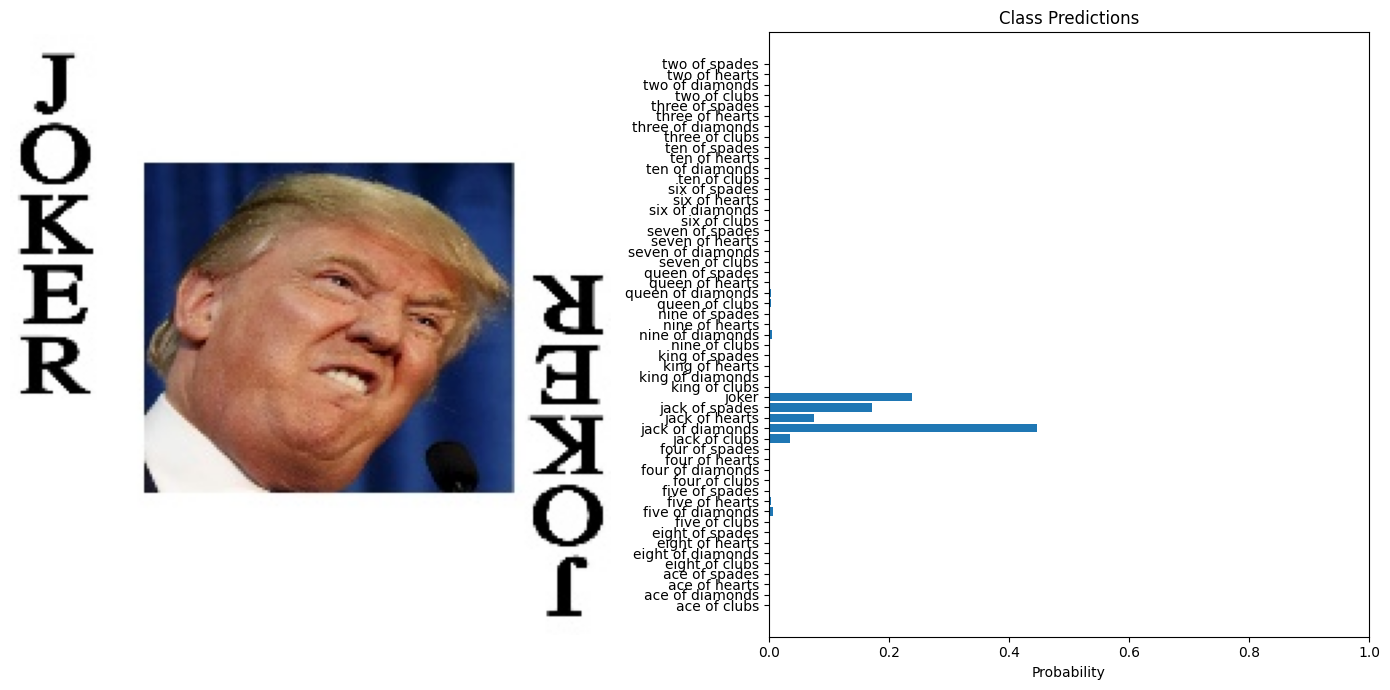

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/cards-image-datasetclassification/test/joker/4.jpg"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

In [ ]:
# Parâmetros
classe_alvo = "joker"
indice_alvo = class_names.index(classe_alvo)

# Lista para salvar os erros
falsos_positivos = []
falsos_negativos = []


# Dataset com caminhos completos
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Recria o dataset com caminhos (caso não tenha acesso)
test_dataset = ImageFolder(root="/content/cards-image-datasetclassification/test", transform=transform)  # ajuste esse caminho
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(tqdm(test_loader)):
        image = image.to(device)
        label = label.item()
        output = model(image)
        pred = torch.argmax(output, dim=1).item()

        img_path, _ = test_dataset.samples[i]  # caminho do arquivo de imagem

        # Falso positivo: previu como jack of diamonds, mas não era
        if pred == indice_alvo and label != indice_alvo:
            falsos_positivos.append((img_path, class_names[label]))

        # Falso negativo: era jack of diamonds, mas previu errado
        if label == indice_alvo and pred != indice_alvo:
            falsos_negativos.append((img_path, class_names[pred]))

# Exibindo os falsos positivos
print(f"\n=== FALSOS POSITIVOS para '{classe_alvo}' ===")
for path, real_class in falsos_positivos:
    print(f"Predito como '{classe_alvo}', mas era '{real_class}': {path}")

# Exibindo os falsos negativos
print(f"\n=== FALSOS NEGATIVOS de '{classe_alvo}' ===")
for path, pred_class in falsos_negativos:
    print(f"Era '{classe_alvo}', mas predito como '{pred_class}': {path}")

  0%|          | 0/265 [00:00<?, ?it/s]


=== FALSOS POSITIVOS para 'joker' ===

=== FALSOS NEGATIVOS de 'joker' ===
Era 'joker', mas predito como 'jack of diamonds': /content/cards-image-datasetclassification/test/joker/1.jpg
Era 'joker', mas predito como 'jack of spades': /content/cards-image-datasetclassification/test/joker/2.jpg
Era 'joker', mas predito como 'jack of diamonds': /content/cards-image-datasetclassification/test/joker/3.jpg
Era 'joker', mas predito como 'jack of diamonds': /content/cards-image-datasetclassification/test/joker/4.jpg


Explicação do processo de aprendizado pelo chat gpt:

Treinamento de Redes Neurais – Resumo Simples

O processo de treinar uma rede neural envolve ensinar a rede a fazer previsões corretas, ajustando seus "botões internos" (os pesos) a cada tentativa. Esse processo ocorre em quatro etapas principais, que se repetem por várias épocas (epochs).

1. Forward Pass (Passagem para Frente)
"Vamos ver o que a rede prevê com o que ela sabe até agora."

Os dados de entrada (por exemplo, uma imagem) passam por todas as camadas da rede.

Cada camada aplica transformações matemáticas nos dados.

No final, a rede gera uma previsão (por exemplo, "gato" ou "cachorro").

Analogia: como se um aluno tentasse responder uma pergunta com o que já sabe.

2. Loss (Função de Perda / Erro)
"O quão errada a rede estava?"

A predição da rede é comparada com a resposta correta.

Calcula-se um número (loss) que representa o quão longe a predição está da resposta certa.

Esse número é calculado com uma função como CrossEntropyLoss.

Analogia: o aluno recebe a nota da prova — errou 3 de 10, nota 7.

3. Backpropagation (Retropropagação do Erro)
"Vamos entender onde a rede errou e de quem foi a culpa."

O erro é propagado de trás para frente pela rede.

Cada camada calcula o quanto contribuiu para o erro.

Essa etapa usa derivadas (gradientes), calculadas automaticamente pelo PyTorch com autograd.

Analogia: o aluno revisa passo a passo a prova e vê onde errou e por quê.

4. Update (Atualização dos Pesos)
"Vamos ajustar os botões internos da rede para que ela erre menos da próxima vez."

A rede usa os gradientes para ajustar os pesos.

O otimizador (como SGD ou Adam) decide como e quanto ajustar.

Isso é feito com um algoritmo chamado gradiente descendente.

Analogia: o aluno estuda os pontos que errou, ajusta o que sabe, e tenta de novo.

Resumo Geral

Etapa	O que faz	Analogia humana

Forward	Passa os dados, gera previsão	Responder a pergunta

Loss	Mede o erro da previsão	Receber a nota

Backpropagation	Descobre de quem foi a culpa do erro	Revisar a prova

Update	Ajusta os pesos com base nos erros	Estudar os erros e melhorar

Esse ciclo se repete muitas vezes (épocas), fazendo a rede melhorar a cada passo até se tornar boa em prever os resultados com base nos dados de entrada.